In [17]:
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.python.keras.layers import SpatialDropout1D
from collections import Counter
from sklearn.utils import shuffle
from tensorflow.keras import backend as K

df = pd.read_csv(r"MoviesDataset.csv")
df.head(10)
# shuffle the dataset
df = shuffle(df)
# rearrange the indexes
df.reset_index(inplace=True, drop=True)


You should consider upgrading via the 'c:\users\ρωμανός\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


### create sentiment histogram

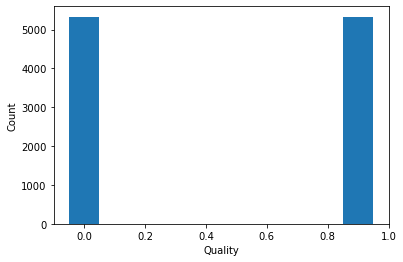

In [18]:
def plot_sentiment_histogram(sentiment): #quality histogram
    unique_vals = df['Sentiment'].sort_values().unique()
    plt.xlabel("Quality")
    plt.ylabel("Count")
    plt.hist(sentiment.values, align='left')
    plt.show()
    
plot_sentiment_histogram(df['Sentiment'])

### split dataset in train and test

In [19]:
X = df['Summary'].values
Y = df['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
max_length = max([len(s.split()) for s in X])
min_length = min([len(s.split()) for s in X])
print(max_length)
print(min_length)

39
1


## Create a dictionary of words

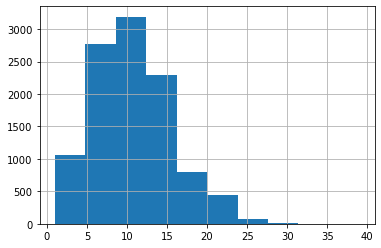

Number of reviews : 819577


In [20]:
reviews_len = [len(x.split()) for x in X]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()
#create a sequence of words
reviews = df['Summary'].values
all_text = ' '.join([c for c in reviews])
reviews_split = all_text.split('\n')

all_text2 = ' '.join(reviews_split)
print('Number of reviews :', len(all_text2))
# create a list of words
words = all_text2.split()  # Count all the words using Counter Method
# Build a dictionary that maps words to integers
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(9000)

## Get unique words

In [21]:
unique = []
for word in words:
    if word not in unique:
        unique.append(word)

#sort
unique.sort()
len(unique)

16319

### Create wordcloud illustration

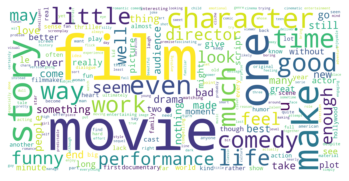

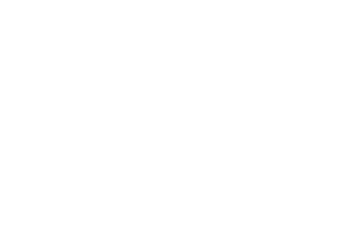

In [22]:
# limit the word count and set the stopwords
wordcount = 500
stopwords = set(STOPWORDS)
stopwords.add("br")

# setup, generate and save the word cloud image to a file
wc = WordCloud(scale=5,
               background_color="white",
               max_words=wordcount,
               stopwords=stopwords)
wc.generate(all_text2)
wc.to_file("WordCloud.png")

# show the wordcloud as output
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

In [23]:
total_words = len(words)
sorted_words = count_words.most_common(total_words)
print(count_words)
X = df['Summary'].values
Y = df['Sentiment'].values


Counter({'film': 1780, 'movie': 1602, 'one': 794, 'like': 740, 'story': 540, 'make': 532, 'character': 494, 'time': 479, 'good': 424, 'comedy': 415, 'much': 388, 'even': 386, 'way': 338, 'well': 334, 'director': 331, 'work': 330, 'performance': 326, 'life': 315, 'little': 307, 'funny': 294, 'feel': 285, 'get': 274, 'enough': 268, 'never': 263, 'u': 254, 'bad': 248, 'may': 245, 'love': 244, 'best': 243, 'year': 241, 'thing': 241, 'would': 232, 'look': 232, 'made': 222, 'take': 219, 'come': 215, 'new': 211, 'drama': 205, 'action': 204, 'something': 202, 'could': 200, 'audience': 199, 'really': 197, 'see': 196, 'two': 195, 'minute': 192, 'plot': 191, 'go': 185, 'still': 184, 'long': 184, 'many': 183, 'old': 180, 'every': 179, 'people': 176, 'big': 176, 'nothing': 175, 'first': 175, 'better': 173, 'end': 172, 'give': 172, 'fun': 169, 'without': 167, 'great': 166, 'picture': 164, 'might': 158, 'actor': 158, 'though': 158, 'world': 156, 'ever': 156, 'cast': 156, 'le': 153, 'also': 153, 'anot

### Pad Sequences

In [24]:
max_seq_length = 30
# convert them into vectors
tokenizer = Tokenizer(num_words=10000)
# Create the vocabulary index based on word frequency
tokenizer.fit_on_texts(X)
# number of the unique words based on the number of elements in this dictionary
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)

# assign an integer to each word
x_train_tokens = tokenizer.texts_to_sequences(X_train)
x_test_tokens = tokenizer.texts_to_sequences(X_test)

# pad all our reviews to a specific length
X_train = pad_sequences(x_train_tokens, maxlen=max_seq_length)
X_test = pad_sequences(x_test_tokens, maxlen=max_seq_length)


Found 16320 unique tokens.


In [25]:
MAX_SEQUENCE_LENGTH = 30
print(vocab_size)
EMBEDDING_DIM = 16


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

16320


### Build model

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=True, batch_size=32)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 16)            261120    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 274,571
Trainable params: 274,571
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
234/234 [==============================] - 8s 36ms/step - loss: 0.6909 - accuracy: 0.5176 - f1_m: 0.5348

### Precision, recall, f1-score and accuracy

In [27]:
print("F1-score")
print(f1_score)
print("Precision")
print(precision)
print("Recall")
print(recall)

F1-score
0.7369166612625122
Precision
0.7189660668373108
Recall
0.7665362358093262


### Test model

In [28]:
test_word = "This is a bad bad movie"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

test_word = "This film is terrible"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

test_word = "This film is great"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw, maxlen=30)
prediction = int(model.predict(tw).round().item())
print(Y[prediction])

0
0
1
